# Outline
The notebook is intended to demonstrate low-level implementation of image deblurring problem without utilizing Deep Learning libraries with JAX.

# Libraries

In [ ]:
%matplotlib inline

from jax.config import config
config.update("jax_enable_x64", True)  #important for L-BFGS

import jax
import jax.numpy as jnp

import pylab as plt
import imageio
import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time
from tqdm.notebook import tqdm

import scipy
from scipy import linalg

from pathlib import Path
from google.colab import drive

from IPython.display import Markdown, display

drive.mount('/content/drive')

SEED = 4212
onp.random.seed(SEED)

def printmd(s):
  display(Markdown(s))

Mounted at /content/drive


In [ ]:
source = Path.cwd() / 'drive' / 'MyDrive' 
p = source.glob('*')
files = [x for x in p if x.is_file()]
files

# Image deblurring

(-0.5, 299.5, 241.5, -0.5)

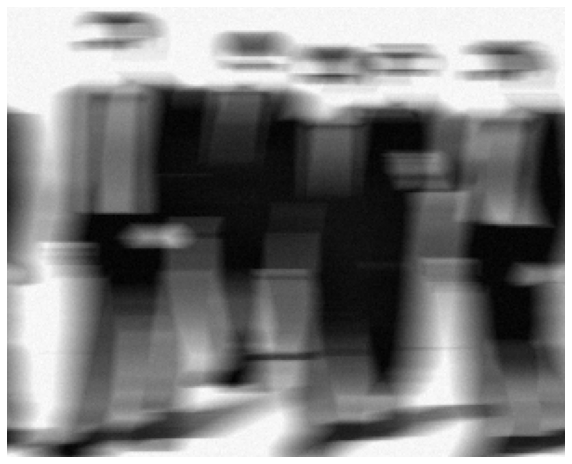

In [ ]:
#load image
path_img = source / 'film.png'

im_blurred = onp.array(imageio.imread(path_img).astype(float))
#display
plt.figure(figsize=(10,10))
plt.imshow(im_blurred, cmap="gray")
plt.axis("off")

To do so, you can assume that this noisy image has been obtained by using the following process.

In [ ]:
def blurr(im):
    S = jnp.zeros_like(im)
    for k in range(30):
        S += jnp.roll(im, shift=(k+1), axis=1)
    return S/30.

#for some unkown clean image "im_clean"
# im_blurred = blurr(im_clean) + onp.random.normal(0,0.01,size=im_clean.shape)

#your job is to find back a good estimate of this unknown clean image.

In [ ]:
#** solution starts here **
w, h = im_blurred.shape
print(w,h)
r = 100
initial_U = onp.random.normal(0,1,size=(w,r)) / onp.sqrt(w*r)
initial_V = onp.random.normal(0,1,size=(r,h)) / onp.sqrt(h*r)

242 300


## Train Model No Regularisation

From the blurr function, we could tell that to restore the image, we need to minimise the loss:

\begin{align}
\sum_{\mathrm{Observed(i,j)}}
        (\mathrm{im\_blurred}_{i,j} - \mathrm{blurr}(Z)_{i,j})^2  \hspace{20mm} 
\end{align}

In [ ]:
@jax.jit
def loss(U, V, reg=0):
    return jnp.mean((im_blurred - blurr(U @ V))**2)
    

grad_loss_u = jax.jit(jax.grad(loss, argnums=0))
grad_loss_v = jax.jit(jax.grad(loss, argnums=1))

In [ ]:
U,V = onp.copy(initial_U), onp.copy(initial_V)
loss(U,V)

DeviceArray(20804.28334706, dtype=float64)

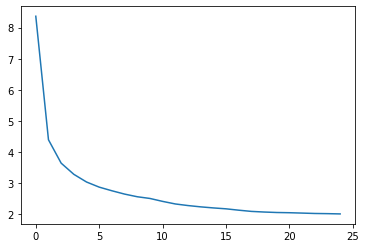

In [ ]:
regularization = 0
norm = 2
LBFGS_iter = 100
n = 25
loss_history = []

for i in tqdm(range(n)):
    V = minimize_U_fixed(U,V, reg=regularization, n_iter=LBFGS_iter)
    U = minimize_V_fixed(U,V, reg=regularization, n_iter=LBFGS_iter)
    loss_history.append(loss(U,V))

plt.plot(loss_history)

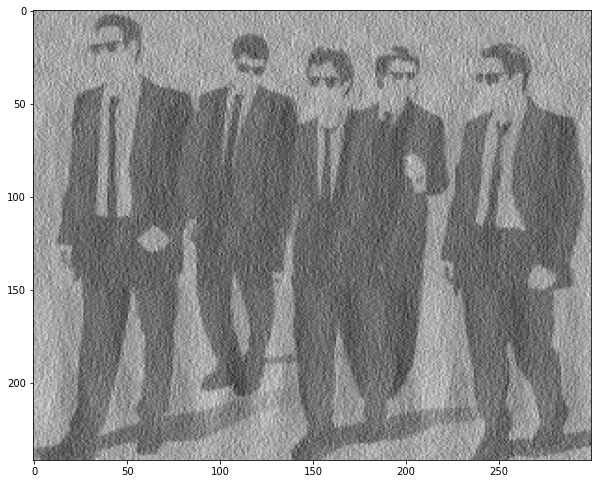

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(U@V, cmap="gray")

## Train Model with Regularization

The un-blurred image is shown above, but we wish to experiment with regularization methods similar to Problem 1. 

As in problem 1, if we tried all possible penalty values and norms, we would have a massive number of models to train. In the interest of time, we fix our norm as the L2 norm and try different values of $\lambda$, then tune for the type of norm.

We denote $Z = UV$ and $||Z||_* \in \{L1, L2, Frobenius, Nuclear\}$, and formulate the regularized optimization problem as follows:

\begin{align}
Z^* &= \underset{Z}{\mathrm{argmin}} 
    \sum_{\mathrm{Observed(i,j)}}
        (\mathrm{im\_blurred}_{i,j} - \mathrm{blurr}(Z)_{i,j})^2  + \lambda||Z||_* \\
\end{align}

In [ ]:
regularization = 10
norm = 2

@jax.jit
def loss(U, V, reg=regularization, norm=norm):
    return jnp.sum((im_blurred - blurr(U @ V))**2) + reg*jnp.linalg.norm(U @ V, ord=norm)
    
grad_loss_u = jax.jit(jax.grad(loss, argnums=0))
grad_loss_v = jax.jit(jax.grad(loss, argnums=1))

In [ ]:
# instantize and compile function so subsequent runs are fastera
U,V = onp.copy(initial_U), onp.copy(initial_V)
loss(U,V)

DeviceArray(1.51039092e+09, dtype=float64)

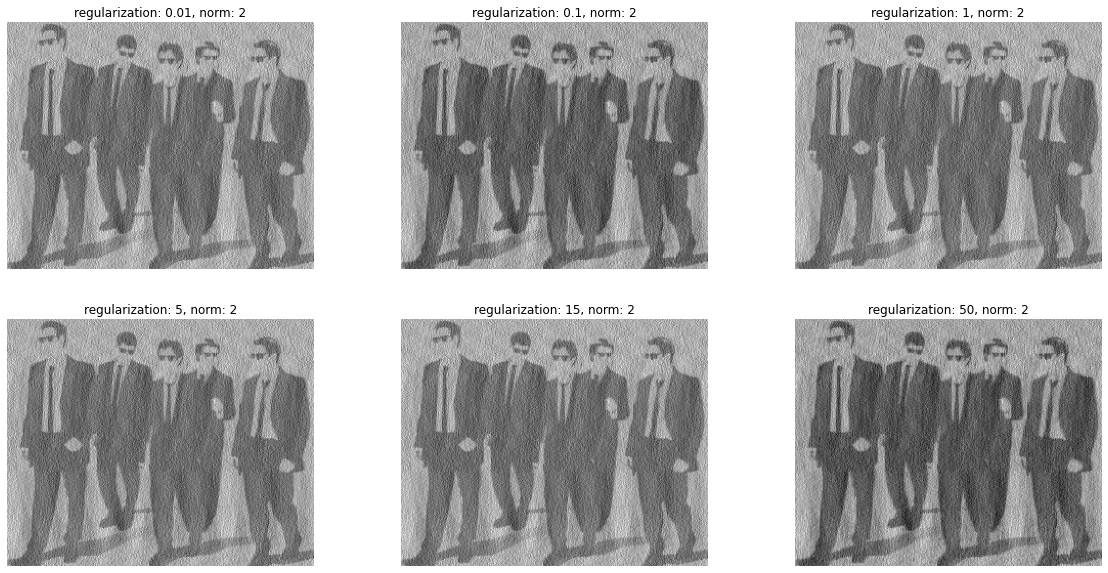

In [ ]:
lambdas = [0.01, 0.1, 1, 5, 15, 50]
d = {}
fig, ax = plt.subplots(2, 3, figsize=(20,10))
count = 0

for row in range(2):
    for col in range(3):

        norm=2
        regularization=lambdas[count]

        @jax.jit
        def loss(U, V, reg=regularization, norm=norm):
            """ calculates the loss """
            return jnp.sum((im_blurred - blurr(U @ V))**2) + reg*jnp.linalg.norm(U@V, ord=norm)
        
        #print(row, col)
        U, V = onp.copy(initial_U), onp.copy(initial_V)
        loss_history=[]
        n = 25
        LBFGS_iter = 100

        for i in range(n):
            V = minimize_U_fixed(U, V, reg=regularization, n_iter=LBFGS_iter)
            U = minimize_V_fixed(U, V, reg=regularization, n_iter=LBFGS_iter)
            loss_history.append(loss(U,V))

        d[regularization] = loss_history
        z = U @ V
        # plot resulting image
        ax[row][col].set_title(f"regularization: {regularization}, norm: {norm}")
        ax[row][col].set_axis_off()
        ax[row][col].imshow(z,cmap="gray")
        count+= 1

From looking at all our images, we observe that the best image quality comes at $\lambda=50$. Now we try different norms.

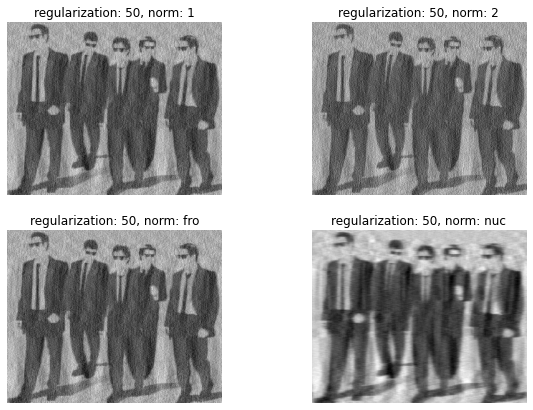

In [ ]:
lambdas = [1, 2, 'fro', 'nuc']
d = {}
fig, ax = plt.subplots(2, 2, figsize=(10,7))
count = 0

for row in range(2):
    for col in range(2):

        norm=norms[count]
        regularization= 50 # best regularization

        @jax.jit
        def loss(U, V, reg=regularization, norm=norm):
            """ calculates the loss """
            return jnp.sum((im_blurred - blurr(U @ V))**2) + reg*jnp.linalg.norm(U@V, ord=norm)
        
        #print(row, col)
        U,V = onp.copy(initial_U), onp.copy(initial_V)
        loss_history=[]
        n = 25
        LBFGS_iter = 100

        for i in range(n):
            V = minimize_U_fixed(U,V, reg=regularization, n_iter=LBFGS_iter)
            U = minimize_V_fixed(U,V, reg=regularization, n_iter=LBFGS_iter)
            loss_history.append(loss(U,V))

        d[regularization] = loss_history
        z = U @ V
        # plot resulting image
        ax[row][col].set_title(f"regularization: {regularization}, norm: {norm}")
        ax[row][col].set_axis_off()
        ax[row][col].imshow(z,cmap="gray")
        count+= 1

From looking at our images, using the Frobenius Norm and L1-norm produces the sharpest de-blurred images, and while using L2-norm also produce a clear picture, it includes significantly more grain. Using the Nuclear Norm does not deblur the image significantly.

## Final Image

The final reconstructed image uses the Frobenius Norm, as well as $\lambda=50$.

In [ ]:
norm='fro' # best regularization norm
regularization=50 # best regularization

@jax.jit
def loss(U, V, reg=regularization, norm=norm):
    """ calculates the loss """
    return jnp.sum((im_blurred - blurr(U @ V))**2) + reg*jnp.linalg.norm(U@V, ord=norm)

In [ ]:
U,V = onp.copy(initial_U), onp.copy(initial_V)
loss_history=[]
n = 25
LBFGS_iter = 100

for i in range(n):
    V = minimize_U_fixed(U,V, reg=regularization, n_iter=LBFGS_iter)
    U = minimize_V_fixed(U,V, reg=regularization, n_iter=LBFGS_iter)
    loss_history.append(loss(U,V))

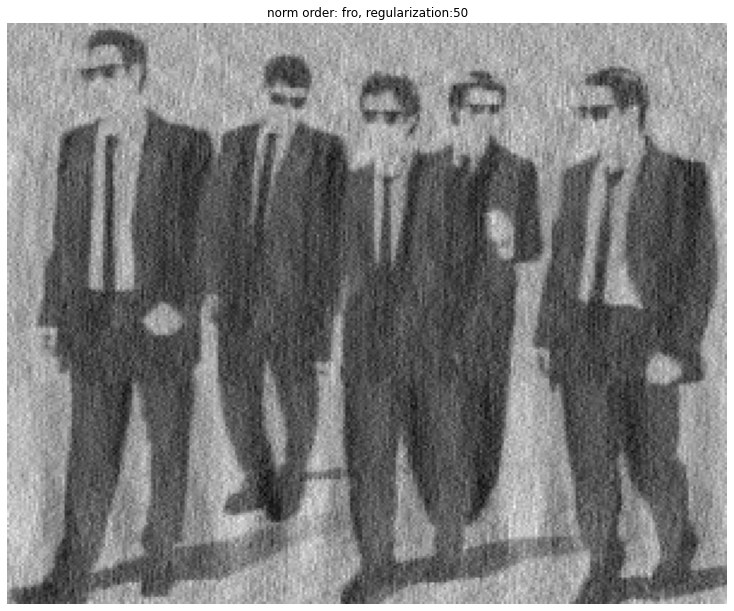

In [ ]:
z = U @ V
# plot resulting image
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.set_title(f"norm order: {norm}, regularization:{regularization}")
ax.set_axis_off()
ax.imshow(z,cmap="gray")
plt.show()